<a href="https://colab.research.google.com/github/Hamxea/Bidirectional-Encoder-Representations-from-Transformers-Turkish-Text-Classification/blob/main/cmp711project_bert_nlp_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

koda geçmeden önce, koddaki BERT ile ilgili olan kısımları https://mccormickml.com/2019/07/22/BERT-fine-tuning/ linkindeki kodlardan yararlanarak oluşturduğumu belirtmek isterim

In [1]:
import pandas as pd
import tensorflow as tf
import torch
import numpy as np
import time
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from google.colab import drive

!!pip install transformers==3.0.0
import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [2]:
# check GPU
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla P100-PCIE-16GB


dosyayı drive'dan okuyabilmeniz için google drive'daki ana klasörünüze resource isminde bir klasör oluşturup, kaggle'dan indirdiğimiz dosyayı *turkish_text_data*.csv olarak kaydetmemiz gerekiyor.

kaggle data'sını linkten indirebilirsiniz: https://www.kaggle.com/savasy/ttc4900

In [3]:
# set environment as googledrive to folder "resource"
data_path =  "/dataset/"

try:
    drive.mount('/content/drive')
    data_path = "/content/drive/My Drive/dataset/"

except:
    print("You are not working in Colab at the moment :(")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv(data_path + 'turkish_text_data.csv', sep=';', encoding='utf-8')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4900 entries, 0 to 4899
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  4900 non-null   object
 1   text      4900 non-null   object
dtypes: object(2)
memory usage: 76.7+ KB


In [6]:
df.groupby('category').size()

category
dunya        700
ekonomi      700
kultur       700
saglik       700
siyaset      700
spor         700
teknoloji    700
dtype: int64

In [7]:
df.drop_duplicates(subset=['text'], keep='first', inplace=True)

df = df.sample(frac=1)
df.reset_index(drop=True, inplace=True)

print(df.groupby('category').count())
print(df.shape)

           text
category       
dunya       677
ekonomi     690
kultur      567
saglik      632
siyaset     690
spor        636
teknoloji   647
(4539, 2)


In [8]:
df.sample(10)

,category,text
1448,saglik,koah aids kadar tehlikeli söz konusu hastalıkt...
2545,spor,hava ve zemin sıkıntı yarattı galatasaray_kulü...
4412,siyaset,erdoğan bize hiç kimse diz çöktüremez başbakan...
3352,ekonomi,içişleri_bakanlığı henüz bir şikayet gelmedi i...
2705,spor,2013 eurobasket in maskotu açıklandı slovenya ...
4385,saglik,eczacılar vitrine ilan asmamalı eczanelerin vi...
4374,kultur,hayat nilgün_belgün ün yıllar önce istanbul yü...
2096,spor,eczacıbaşı liderliğini korudu / ligden görünüm...
249,kultur,yüzüklerin_efendisi davalık oldu  the_hobbit ...
2942,dunya,rusya dan türkiye ye sürpriz destek rusya_dışi...


Kategorik olan label'ları modelde kullanabilmemiz için kategori kolonunu encode etmemiz gerekiyor.

In [9]:
df['encoded_categories'] = LabelEncoder().fit_transform(df['category'])

Bert için gerekli olan 2 ana objeyi, tokenizer'ı ve model'i hugging face'ten indirebilirsiniz: https://huggingface.co/models

tokenizer'ı, önceden sahip olunan kelime haznesini kullanarak metinini ögelerini ayırma işleminde kullanılan araç olarak tanımlayabiliriz. bu tokenizer'daki kelimelere aşağıdaki linkten ulaşabilirsiniz: 
https://s3.amazonaws.com/models.huggingface.co/bert/dbmdz/bert-base-turkish-128k-uncased/vocab.txt

In [10]:
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-128k-uncased', do_lower_case=True)

In [11]:
sentences = df.text.values

metinlerin kelime sayısı 250'den fazla olmasına rağmen girdi uzunluğunu maksimum 250 olarak belirtiyoruz. daha büyük değerlerde GPU'nun memory'si yetmediği için hata alıyoruz. aşağıda göreceğimiz üzere 250 kelimelik metinlerle bile iyi sonuçlar elde edilebiliyor.

In [12]:
max_len = 250

burada elimizdeki metin verisini %80 ve %20 oranıyla, sırasıyla training ve test olarak ikiye bölüyoruz

In [13]:
training = df.groupby('category').apply(lambda x : x.sample(frac = 0.8))
test = pd.concat([df,training]).drop_duplicates(keep=False)

In [14]:
print("Training: ", len(training))
print("Test: ", len(test))

Training:  3633
Test:  906


In [15]:
training_texts = training.text.values
training_labels = training.encoded_categories.values

bu kısımda metin verisini modelde kullanmak üzere işliyoruz. öncelikle cümledeki kelimeler indirdiğimiz tokenizer ile tokenize ediliyor, sonrasında sınıflandırma probleminin çözülebilmesi için gerekli olan token'lar cümlenin sonuna ve başına ekleniyor. cümle maksimum uzunluktan kısaysa, input vektörümüz sabit uzunlukta olduğu için boşluklar dolduruluyor, uzunsa metin limit kadar kelime ile ifade ediliyor. attention mask'leri oluşturuluyor ve metinler işlemin sonucunda tensor objesi olarak geri dönüyor.

aşağıdaki çıktıda da görüldüğü üzere, metindeki kelimeler tokenizer'daki kelimelerin id'leri ile ifade ediliyor ve bu şekilde işleme sokuluyor.

In [16]:
input_ids = []
attention_masks = []

for text in training_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True,
                        max_length = max_len,      
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(training_labels)

print('Original: ', training_texts[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was n

Original:  suriye de ateşkes sağlanırsa ordu kışlasına geri dönsün fransa dışişleri_bakanlığı suriye de bayramda ateşkesin sağlanması halinde düzenli ordunun kışlasına geri dönmesini istedi bakanlık sözcüsü philippe lalliot bm ve arap_birliği nin suriye özel temsilcisi el ahdar el ibrahimi nin suriye nin bayramda ateşkes ilan etmeyi kabul ettiği yolundaki açıklamaları üzerine ülkesinin görüşlerini belirtti lalliot eğer ateşkes sağlanırsa karşılıklı olarak bu düşmanlığın sona ermesi için ateşkesin uzun süreli olması ve düzenli ordunun da barakalarına dönmesi için çalışmak gerekir dedi fransız sözcü halka yönelik baskının suriye ordusundan geldiğini belirterek bu konuda ilk adımın da yine şam yönetiminden gelmesi gerektiğini ifade etti aa
Token IDs: tensor([     2,   4842,   1961,  50428,   9208,   9598,  26492,   4441,   2553,
         25836,   3053,   3720,   2324,   5245,  75582,  80938,     41,  60554,
          1022,   2893,   4842,   1961,  29622,  50428,  21225,   1009,   9598,
  

In [17]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)

oluşturduğumuz tensor verisini modele vermek üzere *dataloader* değişkenine dönüştürüyoruz. 

In [18]:
batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

In [19]:
number_of_categories = len(df['encoded_categories'].unique())

tokenizer'da olduğu gibi, önceden train edilmiş olan modeli fine tune etmek için hugging face'ten indiriyoruz. modelin özelliklerine aşağıdaki linkten ulaşabilirsiniz: 
https://s3.amazonaws.com/models.huggingface.co/bert/dbmdz/bert-base-turkish-128k-uncased/config.json

en altta *model.cuda()* metotu ile modelin GPU'da kullanılacağını belirtiyoruz. 

In [20]:
model = BertForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-128k-uncased",
    num_labels = number_of_categories, 
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

Some weights of the model checkpoint at dbmdz/bert-base-turkish-128k-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassificatio

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(128000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

training'den önceki son adımda, toplam training adım sayısını ve kaç kere training yapılacağı sayısını belirliyoruz. bu sayıların yanında, öğrenmenin daha verimli olabilmesi ve *learning rate* optimizasyonu için bir scheduler yaratılıyor ve optimizer olarak *Adam Optimizer* kullanılıyor.

In [21]:
epochs = 4

optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8 
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [22]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

training aşamasına geçmeden önce seed değerini sabit bir değere eşitliyoruz ki, bütün deneylerimizde aynı sonucu alabilelim.

training, toplam bölüm (epoch) sayısı kadar, bizde 4, kez yapılıyor. yukarıda training verisetini dataloader'a aktarmıştık, girdileri 32'şer 32'şer alıp modeli besliyoruz ve training başlıyor. her bölüm başlamadan önce optimize edilecek loss değeri sıfırlanıyor. modelin *train()* metotu çağırılıyor. çünkü test kısmında *eval()* metotu çağırılıyor. modelin katmanları train ve eval metotlarında farklı olarak davranıyor. dataloader'daki değerler GPU'ya aktarılıyor, gradient değerleri sıfırlanıyor ve output (logit) değerleri oluşuyor ve buna bağlı olarak loss değeri hesaplanıyor. backpropogation ile gradient'ler tekrar hesaplanıyor ve son olarak da learnig rate'le beraber parametreler de optimize ediliyor. her bölümün sonunda ortalama loss'u inceleyebiliriz.

In [23]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 1903

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

======== Epoch 1 / 4 ========
Batch    10  of    114.    Elapsed: 0:00:08.
Batch    20  of    114.    Elapsed: 0:00:15.
Batch    30  of    114.    Elapsed: 0:00:23.
Batch    40  of    114.    Elapsed: 0:00:31.
Batch    50  of    114.    Elapsed: 0:00:39.
Batch    60  of    114.    Elapsed: 0:00:46.
Batch    70  of    114.    Elapsed: 0:00:54.
Batch    80  of    114.    Elapsed: 0:01:02.
Batch    90  of    114.    Elapsed: 0:01:09.
Batch   100  of    114.    Elapsed: 0:01:17.
Batch   110  of    114.    Elapsed: 0:01:25.
Average training loss: 0.56
Training epoch took: 0:01:28
======== Epoch 2 / 4 ========
Batch    10  of    114.    Elapsed: 0:00:08.
Batch    20  of    114.    Elapsed: 0:00:15.
Batch    30  of    114.    Elapsed: 0:00:23.
Batch    40  of    114.    Elapsed: 0:00:31.
Batch    50  of    114.    Elapsed: 0:00:39.
Batch    60  of    114.    Elapsed: 0:00:46.
Batch    70  of    114.    Elapsed: 0:00:54.
Batch    80  of    114.    Elapsed: 0:01:02.
Batch    90  of    114.    E

training'deki model performansı incelemek için loss'daki düşüşü inceliyoruz.

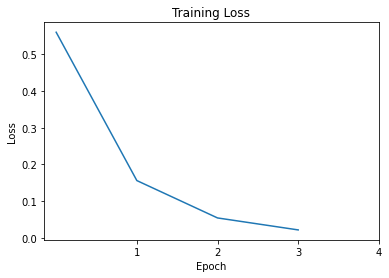

In [24]:
df_stats = pd.DataFrame(data=training_stats)
plt.plot(df_stats['Training Loss'], label="Training")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([1, 2, 3, 4])
plt.show()

training verisetinde olduğu gibi, test veriseti için de bir dataloader oluşturuyoruz.

In [25]:
test_texts = test.text.values
test_labels = test.encoded_categories.values

input_ids = []
attention_masks = []

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = max_len,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',   
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was n

test verisini kullanarak modele sonuçları tahmin ettiriyoruz. batch değerimiz 32 olduğu için, model training'de olduğu gibi prediction kısmında da 32'şer 32'şer input'ları modele veriyor. o yüzden flatten fonksiyonu ile bütün sonuçları tek bir listede topluyoruz ve prediction_set değişkeninde saklıyoruz.

In [26]:
print('Prediction started on test data')
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

print('Prediction completed')

Prediction started on test data
Prediction completed


In [27]:
prediction_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

bu bir sınıflandırma problemi olduğu için performans metriklerinden F-score'u kullanmak istedim. bu kısımda Precision, Recall ve F-score değerlerini çıkartıyoruz, modelin performansını gözlemliyoruz.

In [28]:
f_score = f1_score(test_labels, prediction_scores, average='macro')
precision = precision_score(test_labels, prediction_scores, average='macro')
recall = recall_score(test_labels, prediction_scores, average='macro')

görüldüğü üzere, kısıtlı bir veriseti ile bile iyi bir performans edilebiliyor. verisetinin kısıtlı olmasının dışında, cümlelerde 250'den fazla kelime olmasına rağmen, input layer kısmında her cümle 250 kelimeyle ifade edilip yüksek F-score elde edilebildi.

In [29]:
print("F-Score: ", f_score)
print("Recall: ", recall)
print("Precision: ", precision)

F-Score:  0.9434813268147255
Recall:  0.9442785469020961
Precision:  0.9433928044258203


In [30]:
report = pd.DataFrame(classification_report(test_labels, prediction_scores, output_dict=True))

In [31]:
report = report.rename(columns={'0':'dunya',
                          '1':'ekonomi',
                          '2':'kultur',
                          '3':'saglik',
                          '4':'siyaset',
                          '5':'spor',
                          '6':'teknoloji'})

In [32]:
report

,dunya,ekonomi,kultur,saglik,siyaset,spor,teknoloji,accuracy,macro avg,weighted avg
precision,0.937984,0.888889,0.933333,0.937008,0.969466,0.992188,0.944882,0.942605,0.943393,0.943166
recall,0.896296,0.927536,0.991150,0.944444,0.920290,1.000000,0.930233,0.942605,0.944279,0.942605
f1-score,0.916667,0.907801,0.961373,0.940711,0.944238,0.996078,0.937500,0.942605,0.943481,0.942534
support,135.000000,138.000000,113.000000,126.000000,138.000000,127.000000,129.000000,0.942605,906.000000,906.000000
